# Model Creation for Toxicity Classifier

In [2]:
import os
import pandas as pd


using_colab = False

## Downloading Datasets from Kaggle

In [3]:
if using_colab:
    from google.colab import drive
    drive.mount('/gdrive')
    # Check current location, '/content' is the Colab virtual machine
    print(os.getcwd())
    # Enable the Kaggle environment, use the path to the directory your Kaggle API JSON is stored in
    os.environ['KAGGLE_CONFIG_DIR'] = '../gdrive/MyDrive/Kaggle'

    !kaggle datasets download -d ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text
    !kaggle datasets download -d oswinrh/indonesian-stoplist

    !unzip 'indonesian-abusive-and-hate-speech-twitter-text.zip' -d 'abusive_text_dataset'
    !unzip 'indonesian-stoplist.zip' -d 'stoplist_dataset'

## Importing Datasets Using Pandas

note: abusive sentences is the training data

In [4]:
if using_colab:
    stopwords_path = '/content/stoplist_dataset/stopwordbahasa.csv'
    abusive_words_path = '/content/abusive_text_dataset/abusive.csv'
    alay_words_path = '/content/abusive_text_dataset/new_kamusalay.csv'
    abusive_sentences_path = '/content/abusive_text_dataset/data.csv'

if not using_colab:
    stopwords_path = './dataset/stopwordbahasa.csv'
    abusive_words_path = './dataset/abusive.csv'
    alay_words_path = './dataset/new_kamusalay.csv'
    abusive_sentences_path = './dataset/data.csv'

df_stopwords = pd.read_csv(stopwords_path, header=None)
df_stopwords = df_stopwords.rename(columns={0: 'stopword'})
df_abusive = pd.read_csv(abusive_words_path, encoding='latin-1')
df_alay = pd.read_csv(alay_words_path, encoding='latin-1', header=None)
df_alay = df_alay.rename(columns={0: 'original', 
                                  1: 'replacement'})
df_alay_map = dict(zip(df_alay['original'], df_alay['replacement']))
df_abusive_sentences = pd.read_csv(abusive_sentences_path, encoding='latin-1') 

### Checking the structure of each DataFrame




In [5]:
df_stopwords

,stopword
0,ada
1,adalah
2,adanya
3,adapun
4,agak
...,...
753,wong
754,yaitu
755,yakin
756,yakni


In [6]:
df_abusive

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing
...,...
120,rezim
121,sange
122,serbet
123,sipit


In [7]:
df_alay

,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
...,...,...
15162,mendikbud,menteri pendidikan dan kebudayaan
15163,mendag,menteri perdagangan
15164,menaker,menteri tenaga kerja
15165,memetwit,mentwit


In [8]:
df_abusive_sentences

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,1,0,0
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,0,0,0
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,0,0,0
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0


### Checking if HS column corresponds with the HS_X columns

In [9]:
condition = df_abusive_sentences['HS'] != (df_abusive_sentences[df_abusive_sentences.columns[3:]].any(axis=1))
df_abusive_sentences[condition]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong


Therefore HS column is correct, HS will be 1 if any of HS_X columns contains 1

### Checking Dataset if there are abusive word but not labelled abusive

In [10]:
df_abusive

,ABUSIVE
0,alay
1,ampas
2,buta
3,keparat
4,anjing
...,...
120,rezim
121,sange
122,serbet
123,sipit


In [11]:
df_abusive_sentences

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13164,USER jangan asal ngomong ndasmu. congor lu yg ...,1,1,1,0,0,0,1,0,0,1,0,0
13165,USER Kasur mana enak kunyuk',0,1,0,0,0,0,0,0,0,0,0,0
13166,USER Hati hati bisu :( .g\n\nlagi bosan huft \...,0,0,0,0,0,0,0,0,0,0,0,0
13167,USER USER USER USER Bom yang real mudah terdet...,0,0,0,0,0,0,0,0,0,0,0,0


In [12]:
contains_abusive = df_abusive_sentences["Tweet"].apply(lambda x: any(item for item in df_abusive['ABUSIVE'].tolist() if item in x.lower().split(' ')))
hs_or_abusive = df_abusive_sentences['HS'] | df_abusive_sentences['Abusive']
condition = (contains_abusive != hs_or_abusive) & (contains_abusive == True)
df_abusive_sentences[condition]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
16,Belakangan ini kok fikiran ampas banget ya',0,0,0,0,0,0,0,0,0,0,0,0
21,USER kalo kamu noob pasti peluang disakitin ny...,0,0,0,0,0,0,0,0,0,0,0,0
31,Dari habis sahur sampe jam 10. Sibayik udah ne...,0,0,0,0,0,0,0,0,0,0,0,0
32,USER Gak kak emak mah gak demen ama yang sipit...,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13116,USER Rezim kemarin saya dan keluarga pilih dem...,0,0,0,0,0,0,0,0,0,0,0,0
13119,USER USER USER USER USER USER USER USER USER B...,0,0,0,0,0,0,0,0,0,0,0,0
13136,"USER USER Kapan bib? Gk sabr nih,mau potong on...",0,0,0,0,0,0,0,0,0,0,0,0
13149,RT USER: Foto ke 3:\n\nPohon tempat koloni mon...,0,0,0,0,0,0,0,0,0,0,0,0


In [29]:
not_counted_abusive_words_dict = {}
for sentence in df_abusive_sentences[condition]['Tweet'].values:
    for word in df_abusive['ABUSIVE'].values:
        if word in sentence.split(' '):
            if word in not_counted_abusive_words_dict.keys():
                not_counted_abusive_words_dict[word] += 1
            else:
                not_counted_abusive_words_dict[word] = 1

In [30]:
    dict(sorted(not_counted_abusive_words_dict.items(), key=lambda x:x[1], reverse=True))

{'asing': 186,
 'sipit': 90,
 'rezim': 89,
 'cacat': 67,
 'antek': 66,
 'komunis': 65,
 'buta': 52,
 'kafir': 50,
 'onta': 35,
 'bisu': 34,
 'buaya': 34,
 'rejim': 34,
 'taplak': 31,
 'monyet': 28,
 'munafik': 26,
 'sampah': 25,
 'bangkai': 22,
 'jamban': 15,
 'gila': 14,
 'bani': 14,
 'kunti': 13,
 'budek': 13,
 'transgender': 12,
 'babi': 11,
 'anjing': 11,
 'gendut': 11,
 'ateis': 11,
 'lesbi': 10,
 'tuyul': 10,
 'culun': 9,
 'jijik': 9,
 'noob': 8,
 'setan': 8,
 'autis': 8,
 'ampas': 7,
 'iblis': 7,
 'lgbt': 7,
 'kejam': 6,
 'idiot': 6,
 'hina': 5,
 'tai': 5,
 'udik': 5,
 'goblok': 4,
 'cupu': 4,
 'gay': 4,
 'alay': 4,
 'celeng': 3,
 'bokong': 3,
 'bodoh': 3,
 'terkutuk': 2,
 'sitip': 2,
 'cebong': 2,
 'nete': 1,
 'banci': 1,
 'kunyuk': 1,
 'ngewe': 1,
 'gembrot': 1,
 'kampungan': 1,
 'pantat': 1,
 'jablay': 1,
 'lengser': 1,
 'nista': 1,
 'najis': 1,
 'pecun': 0,
 'cungkring': 0,
 'sarap': 0,
 'sinting': 0,
 'homo': 0,
 'bencong': 0,
 'sange': 0,
 'anjir': 0,
 'burik': 0,
 'koreng

In [31]:
df_abusive_sentences.loc[condition, 'Abusive'] = 1

# For checking
df_abusive_sentences.iloc[[3,16,21,31,32],:]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,1,0,0,0,0,0,0,0,0,0,0
16,Belakangan ini kok fikiran ampas banget ya',0,1,0,0,0,0,0,0,0,0,0,0
21,USER kalo kamu noob pasti peluang disakitin ny...,0,1,0,0,0,0,0,0,0,0,0,0
31,Dari habis sahur sampe jam 10. Sibayik udah ne...,0,1,0,0,0,0,0,0,0,0,0,0
32,USER Gak kak emak mah gak demen ama yang sipit...,0,1,0,0,0,0,0,0,0,0,0,0


We will apply the same process after preprocessing the text incase if there are still the same cases occuring after preprocessing step.

## Data Preprocessing

In [32]:
!pip install PySastrawi

In [33]:
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
factory = StemmerFactory()
stemmer = factory.create_stemmer()

def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('\r',' ',text) # Remove every '\r'
    text = re.sub('(?i)rt',' ',text) # Remove every retweet symbol
    text = re.sub('@[^\s]+[ \t]','',text) # Remove every username
    text = re.sub('(?i)user','',text) # Remove every username
    text = re.sub('(?i)url',' ',text) # Remove every url
    text = re.sub(r'\\x..',' ',text) # Remove every emoji
    text = re.sub('  +', ' ', text) # Remove extra spaces
    text = re.sub(r'(\w)\1{2,}', r'\1\1', text) #Remove characters repeating more than twice

    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 

    return text

def normalize_alay(text):
    words = text.split(' ')
    normalized_words= []
    for word in words:
      if word in df_alay_map:
        normalized_words.append(df_alay_map[word])
      else:
        normalized_words.append(word)
      normalized_sentences = " ".join(normalized_words)
    return normalized_sentences

def remove_stopword(text):
    cleaned_words= []
    for word in text.split(' '):
      if word in df_stopwords['stopword'].values:
        cleaned_words.append('')
      else:
        cleaned_words.append(word)
      cleaned_sentences = ' '.join(cleaned_words)
    cleaned_sentences = re.sub('  +', ' ', cleaned_sentences) # Remove extra spaces
    cleaned_sentences = cleaned_sentences.strip()
    return cleaned_sentences

def stemming(text):
    return stemmer.stem(text)

def preprocess(text):
    text = remove_unnecessary_char(text)
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = normalize_alay(text)
    text = remove_stopword(text)
    text = stemming(text)

    return text


In [42]:
clean_df = df_abusive_sentences.copy()
clean_df['Tweet'] = clean_df['Tweet'].apply(preprocess)

In [43]:
contains_abusive = clean_df["Tweet"].apply(lambda x: any(item for item in df_abusive['ABUSIVE'].values if item in x.lower().split(' ')))
hs_or_abusive = clean_df['HS'] | clean_df['Abusive']
condition = (contains_abusive != hs_or_abusive) & (contains_abusive == True)
clean_df[condition]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
65,hem hem diam bisu coba rumput goyang,0,0,0,0,0,0,0,0,0,0,0,0
67,ateis sibuk agama orang,0,0,0,0,0,0,0,0,0,0,0,0
73,ajar salat a orang asing pecah belah islam,0,0,0,0,0,0,0,0,0,0,0,0
86,muslim nista kitab suci alquran an alquran an ...,0,0,0,0,0,0,0,0,0,0,0,0
88,bentar gue rilis album the onta si wkwk,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13072,cinta buta,0,0,0,0,0,0,0,0,0,0,0,0
13078,anti asing kampanye,0,0,0,0,0,0,0,0,0,0,0,0
13079,kabur dapat presiden soekarno kabinet presiden...,0,0,0,0,0,0,0,0,0,0,0,0
13082,fanatik kayak jatuh cinta bikin buta tuli bisu,0,0,0,0,0,0,0,0,0,0,0,0


In [44]:
not_counted_abusive_words_dict = {}
# count = 0 
for sentence in clean_df[condition]['Tweet'].values:
    # count += 1
    # print(count)
    for word in df_abusive['ABUSIVE'].values:
        if word in sentence.split(' '):
            # print(f"word: {word}")
            # print(f"sentence: {sentence}")
            if word in not_counted_abusive_words_dict.keys():
                not_counted_abusive_words_dict[word] += 1
            else:
                not_counted_abusive_words_dict[word] = 1

dict(sorted(not_counted_abusive_words_dict.items(), key=lambda x:x[1], reverse=True))

{'asing': 175,
 'komunis': 135,
 'sipit': 47,
 'tai': 38,
 'cacat': 35,
 'bisu': 31,
 'kafir': 29,
 'buta': 29,
 'nista': 28,
 'onta': 25,
 'hina': 23,
 'bodoh': 23,
 'monyet': 18,
 'buaya': 18,
 'kunti': 17,
 'rezim': 16,
 'ateis': 14,
 'gila': 13,
 'ngewe': 12,
 'antek': 12,
 'seks': 11,
 'bangkai': 9,
 'anjing': 9,
 'jamban': 9,
 'idiot': 9,
 'sampah': 8,
 'munafik': 8,
 'gendut': 8,
 'babi': 8,
 'lgbt': 7,
 'ampas': 6,
 'bejat': 5,
 'udik': 5,
 'sinting': 5,
 'culun': 5,
 'autis': 5,
 'iblis': 4,
 'cebong': 4,
 'lesbi': 4,
 'taplak': 4,
 'transgender': 4,
 'jijik': 4,
 'setan': 4,
 'kejam': 4,
 'panasbung': 4,
 'bong': 4,
 'bani': 4,
 'budek': 3,
 'tuyul': 3,
 'kontol': 3,
 'rejim': 3,
 'dungu': 3,
 'mucikari': 2,
 'silit': 2,
 'koreng': 2,
 'cungkring': 2,
 'noob': 2,
 'gay': 2,
 'panastak': 2,
 'burik': 2,
 'dongok': 2,
 'anjir': 2,
 'najis': 2,
 'bencong': 2,
 'bacot': 1,
 'pecun': 1,
 'nete': 1,
 'berengsek': 1,
 'bokep': 1,
 'goblok': 1,
 'sontoloyo': 1,
 'alay': 1,
 'edan': 1

In [45]:
clean_df.loc[condition, 'Abusive'] = 1

clean_df.iloc[[65,67,73,86,88], :]

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
65,hem hem diam bisu coba rumput goyang,0,1,0,0,0,0,0,0,0,0,0,0
67,ateis sibuk agama orang,0,1,0,0,0,0,0,0,0,0,0,0
73,ajar salat a orang asing pecah belah islam,0,1,0,0,0,0,0,0,0,0,0,0
86,muslim nista kitab suci alquran an alquran an ...,0,1,0,0,0,0,0,0,0,0,0,0
88,bentar gue rilis album the onta si wkwk,0,1,0,0,0,0,0,0,0,0,0,0


## Text Vectorization

In [46]:
import tensorflow as tf
print(tf.__version__)

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices());
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()));

2.8.0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14483306410898692716
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3667263488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5067831641433833057
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]
Default GPU Device: /device:GPU:0


In [47]:
# Run if Tensorflow version < 2.0
# !pip install --upgrade tensorflow

In [48]:
from tensorflow.keras.layers import TextVectorization

In [61]:
x = clean_df['Tweet']
y = clean_df[['HS','Abusive']].values

In [62]:
# Count unique words in sentences dataset
from collections import Counter
results = Counter()
clean_df['Tweet'].str.lower().str.split().apply(results.update)
print(len(results))

12787


In [63]:
max_features = 15000

In [64]:
vectorizer = TextVectorization(max_tokens=max_features,
                               output_sequence_length=300,
                               output_mode='int')
vectorizer.adapt(x.values)
vectorized_text = vectorizer(x.values)


In [65]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache().shuffle(160000).batch(16).prefetch(8) #adjust constants based on dataset

In [66]:
train = dataset.take(int(len(dataset)*.8))
val = dataset.skip(int(len(dataset)*.8)).take(int(len(dataset)*.1))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

## Building the Model

In [67]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense

In [68]:
model = tf.keras.models.Sequential()

model.add(Embedding(max_features+1, 64))
model.add(Bidirectional(LSTM(32, activation='tanh', )))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [69]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 64)          960064    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 256)               65792     
                                                                 
 dense_7 (Dense)             (None, 2)                 514       
                                                      

### Training the Model

In [70]:
history = model.fit(train, epochs=30, validation_data=val)

Epoch 1/30
576/576 [==============================] - 20s 31ms/step - loss: 0.4403 - accuracy: 0.5828 - val_loss: 0.2467 - val_accuracy: 0.5945
Epoch 2/30
576/576 [==============================] - 17s 30ms/step - loss: 0.2541 - accuracy: 0.6686 - val_loss: 0.1809 - val_accuracy: 0.6212
Epoch 3/30
576/576 [==============================] - 17s 30ms/step - loss: 0.1912 - accuracy: 0.7010 - val_loss: 0.1342 - val_accuracy: 0.7298
Epoch 4/30
576/576 [==============================] - 18s 31ms/step - loss: 0.1484 - accuracy: 0.7221 - val_loss: 0.1139 - val_accuracy: 0.7306
Epoch 5/30
576/576 [==============================] - 18s 30ms/step - loss: 0.1142 - accuracy: 0.7270 - val_loss: 0.0830 - val_accuracy: 0.7454
Epoch 6/30
576/576 [==============================] - 18s 31ms/step - loss: 0.0951 - accuracy: 0.7322 - val_loss: 0.0580 - val_accuracy: 0.7790
Epoch 7/30
576/576 [==============================] - 17s 30ms/step - loss: 0.0743 - accuracy: 0.7352 - val_loss: 0.0627 - val_accuracy:

In [71]:
from matplotlib import pyplot as plt

<Figure size 1152x648 with 0 Axes>

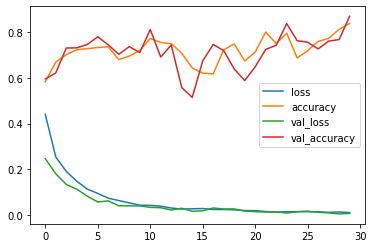

In [72]:
plt.figure(figsize=(16,9))
pd.DataFrame(history.history).plot()
plt.show()

# Testing the Model with User Inputs

In [52]:
input_text = vectorizer('bego lu')
res = model.predict(np.expand_dims(input_text,0)
(res > 0.5).astype(int)
res.shape

ValueError: in user code:

    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1801, in predict_function  *
        return step_function(self, iterator)
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1790, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1783, in run_step  **
        outputs = model.predict_step(data)
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\training.py", line 1751, in predict_step
        return self(x, training=False)
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "d:\Anaconda3\envs\Deep_Learning\lib\site-packages\keras\engine\input_spec.py", line 214, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_1" (type Sequential).
    
    Input 0 of layer "bidirectional_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 32)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None,), dtype=int64)
      • training=False
      • mask=None


In [53]:
batch = test.as_numpy_iterator().next()
batch_x, batch_y = test.as_numpy_iterator().next()
(model.predict(batch_x) > 0.5).astype(int)

NameError: name 'batch_X' is not defined

# Converting to TensorFlow Lite